# `meanderpy` River Example

This notebook focuses on using the `meanderpy` package to generate synthetic river networks that will be used to test `WigglyRivers` functionallity on detecting meanders and calculating metrics. 

`meanderpy` is a Python package that produces meandering rivers using a simple kinematic model presented in Howard & Knutson (1984) (Sylvester, Z., 2023). The package GitHub repository can be found [here](https://github.com/zsylvester/meanderpy) and can be installed using the following command:

```bash
pip install meanderpy
```

To start this example we first import the packages necessary to run the code.

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

In [2]:
# Importing Packages
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import Image, display, HTML
from IPython.display import display
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean
from scipy import interpolate
import statsmodels.api as sm
from scipy.signal import find_peaks

import meanderpy as mp

# Importing WigglyRivers Packages
from WigglyRivers import RiverDatasets, RiverTransect
from WigglyRivers import RiverFunctions as RF
from WigglyRivers import ExtractNHDPlusHRData as NHD
from WigglyRivers.utilities import utilities as utl
from WigglyRivers.utilities import filesManagement as FM
from WigglyRivers.utilities import graphs
from WigglyRivers import Logger
from WigglyRivers import WaveletTreeFunctions as WTFunc
from WigglyRivers import iwavelet

# Set seed for numpy
np.random.seed(0)
fs = 14
mpl.rcParams['font.size'] = fs
mpl.rcParams['font.family'] = 'Times New Roman'

In [3]:
# Start Logger
logger = Logger(console=True)

2024-05-02 15:56:03,493[INFO] set_logger: Starting log


## Synthetic River Networks Analysis

### Generate Synthetic Rivers

We use the example in the `meanderpy` repository to generate a series of synthetic rivers that will be used in our analysis. The code below will generate and save four meandering rivers with multiple complexities. From the simple sinuos-like river to the more complex river with multiple bends and loops.

**Keep in mind that the model will take some time to run.**

In [4]:
# ------------------------------
# Create River with meanderpy
# ------------------------------
nit = 1500                   # number of iterations
W = 200                      # channel width (m)
D = 6.0                     # channel depth (m)
depths = D * np.ones((nit,))  # channel depths for different iterations
pad = 100                    # padding (number of nodepoints along centerline)
deltas = 50.0                # sampling distance along centerline
Cfs = 0.011 * np.ones((nit,)) # dimensionless Chezy friction factor
crdist = 2 * W               # threshold distance at which cutoffs occur
kl = 60.0/(365*24*60*60.0)   # migration rate constant (m/s)
kv =  1.0e-12               # vertical slope-dependent erosion rate constant (m/s)
dt = 2*0.05*365*24*60*60.0     # time step (s)
dens = 1000                  # density of water (kg/m3)
saved_ts = 20                # which time steps will be saved
n_bends = 100                 # approximate number of bends you want to model
Sl = 0.0                     # initial slope (matters more for submarine channels than rivers)
t1 = 500                    # time step when incision starts
t2 = 700                    # time step when lateral migration starts
t3 = 1200                    # time step when aggradation starts
aggr_factor = 2e-9         # aggradation factor (m/s, about 0.18 m/year, it kicks in after t3)

ch = mp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends) # initialize channel
chb = mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[]) # create channel belt object

chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor) # channel migration
# migrate an additional 1000 iterations and plot results
chb.migrate(1000,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor)

# ------------------------------
# Save Dataset
# ------------------------------
n_channels = len(chb.channels)
channels_to_save = [50, 80, 123]
data = {}
for i, i_ch in enumerate(channels_to_save):
    x_ch = chb.channels[i_ch].x
    y_ch = chb.channels[i_ch].y
    data[str(i)] = {'x': x_ch, 'y': y_ch}

FM.save_data(data, path_output='synthetic_rivers/',
             file_name='synthetic_rivers_meanderpy.hdf5')
print('Synthetic Rivers Generated and Saved Succesfully')

100%|██████████| 1000/1000 [04:15<00:00,  3.91it/s]

Synthetic Rivers Generated and Saved Succesfully


Let's look at the meandering channels generated by `meanderpy`:

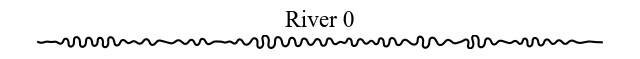

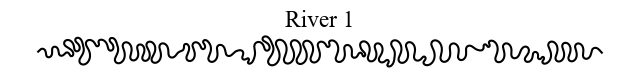

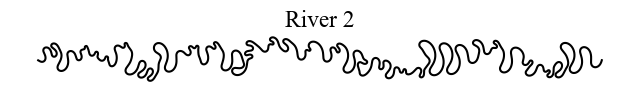

In [5]:
data = FM.load_data('synthetic_rivers/synthetic_rivers_meanderpy.hdf5')
river_ids = list(data.keys())
plt.close('all')
for river_id in river_ids:
    x_ch = data[river_id]['x'][155:-155]
    y_ch = data[river_id]['y'][155:-155]
    plt.figure(figsize=(8, 1))
    plt.plot(x_ch, y_ch, '-k')
    # plt.plot(x_ch, y_ch, 'ob')
    plt.title(f'River {river_id}')
    plt.gca().set_aspect('equal', adjustable='box')
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    # Remove axis lines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    utl.cr_folder('synthetic_rivers/results')
    plt.savefig(f'synthetic_rivers/results/river_{river_id}.png', dpi=300)
    plt.show()


### Adding Noise to the River

To reflect real data samples, we added noise into the synthetic rivers and included that information into the data for comparison. We also perform the numerical computation of the curvature of the original coordiates to have a comparison to the ones calculated by `WigglyRivers`.


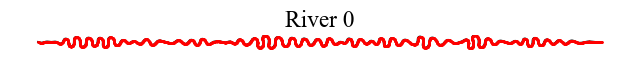

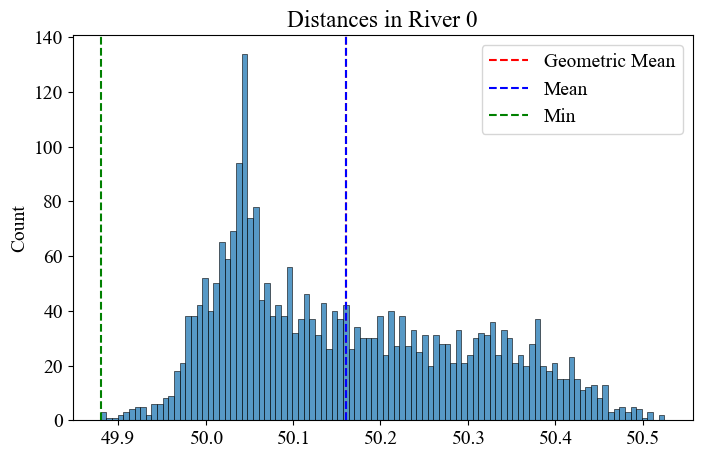

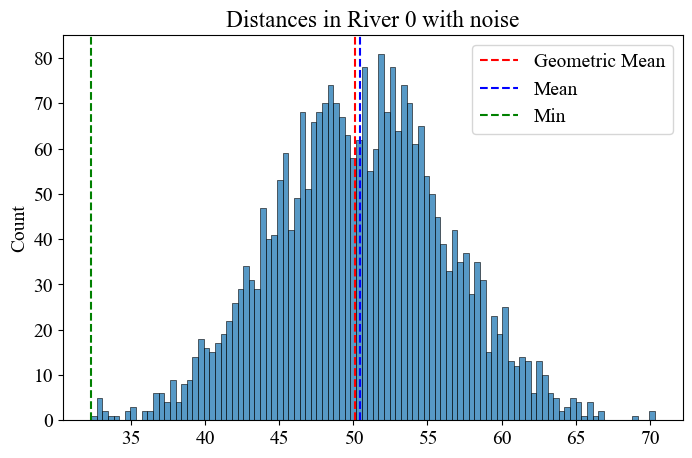

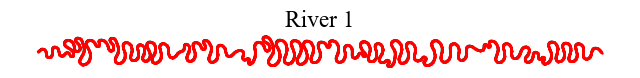

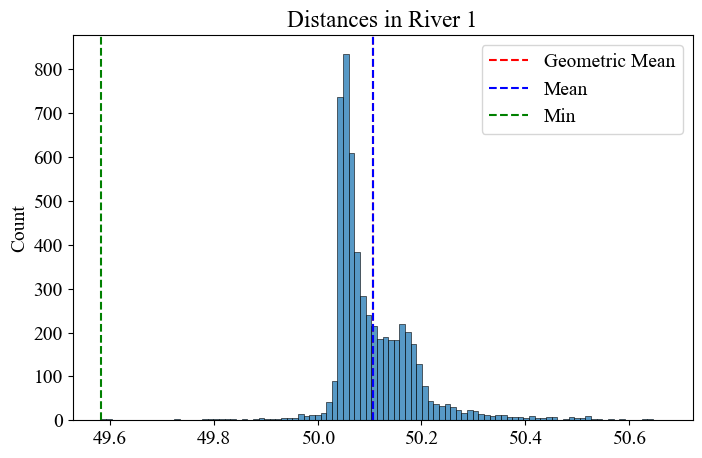

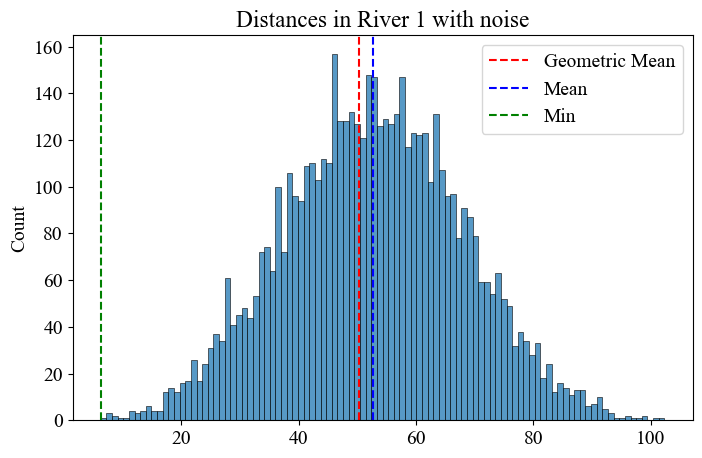

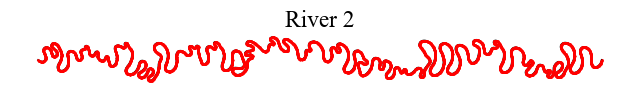

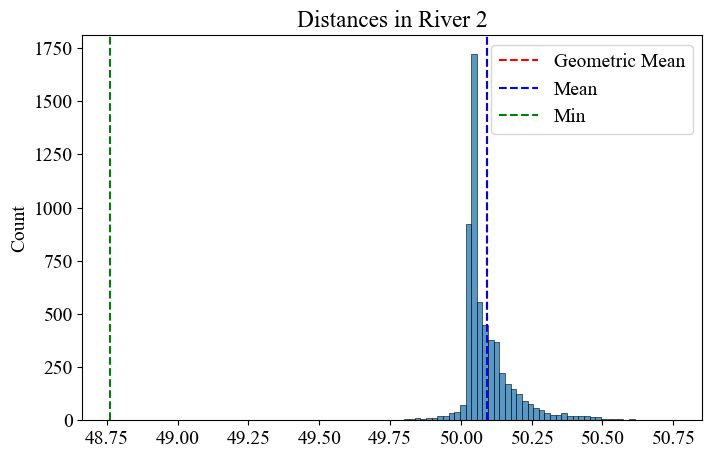

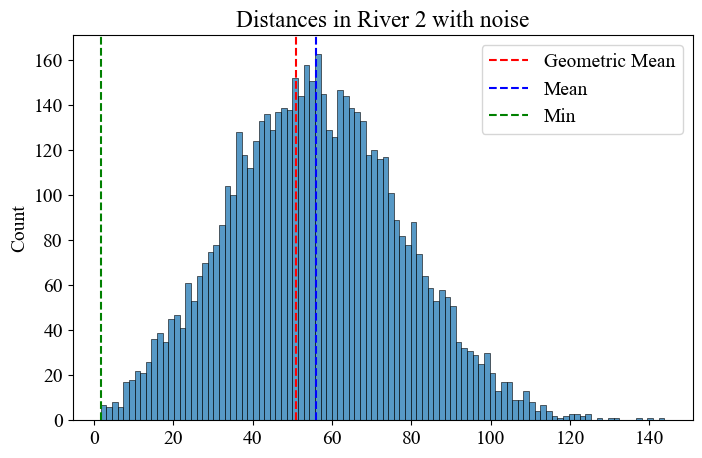

In [6]:
# Load river data
data = FM.load_data('synthetic_rivers/synthetic_rivers_meanderpy.hdf5')
river_ids = list(data.keys())

utl.cr_folder('synthetic_rivers/results')

plt.close('all')

# Loop throug the rivers
for id_river_general in river_ids:
    # ------------------------------
    # Select River to perform analysis
    # ------------------------------
    x_ch = data[id_river_general]['x'][155:-155]
    y_ch = data[id_river_general]['y'][155:-155]
    coords = np.array([x_ch, y_ch]).T
    s_ch = RF.get_reach_distances(coords)
    ds = np.diff(s_ch)
    ds = np.append(ds[0], ds)
    # Curvature original data
    _, c_ch, _ = RF.calculate_curvature(s_ch, x_ch, y_ch)

    # ------------------------------
    # Noise
    # ------------------------------
    # Use a linear model to get a sense of the added noise
    line_model = sm.OLS(y_ch, x_ch).fit()
    sd_resid = np.std(line_model.resid)
    sigma = sd_resid/100
    # Add noise to the coordiantes
    x_ch_noise = x_ch + np.random.normal(0, sigma, size=len(x_ch))
    y_ch_noise = y_ch + np.random.normal(0, sigma, size=len(y_ch))
    coords = np.array([x_ch_noise, y_ch_noise]).T
    s_ch_noise = RF.get_reach_distances(coords)
    ds_noise = np.diff(s_ch_noise)
    ds_noise = np.append(ds_noise[0], ds_noise)

    # ------------------------------
    # Calculate additional variables
    # ------------------------------
    # Width
    w_m = np.ones_like(x_ch) * 200.0

    w_m_gm = 10**np.mean(np.log10(w_m))
    geometric_mean_value = 10**np.mean(np.log10(ds))
    mean_value = np.mean(ds)
    min_value = np.min(ds)

    gm_noise = 10**np.mean(np.log10(ds_noise))
    mean_noise = np.mean(ds_noise)
    min_noise = np.min(ds_noise)
    # ------------------------------
    # Save noisy data
    # ------------------------------
    data[id_river_general]['x'] = x_ch
    data[id_river_general]['y'] = y_ch
    data[id_river_general]['c'] = c_ch
    data[id_river_general]['s'] = s_ch
    data[id_river_general]['ds'] = ds
    data[id_river_general]['x_noise'] = x_ch_noise
    data[id_river_general]['y_noise'] = y_ch_noise
    data[id_river_general]['s_noise'] = s_ch_noise
    data[id_river_general]['w_m'] = w_m

    # ------------------------------
    # Plots
    # ------------------------------
    plt.figure(figsize=(8, 3))
    plt.title(f'River {id_river_general}')
    plt.plot(x_ch, y_ch, '-k')
    plt.plot(x_ch_noise, y_ch_noise, '.r', markersize=1.5)
    plt.gca().set_aspect('equal', adjustable='box')
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    # Remove axis lines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.show()

    data_df = pd.DataFrame({'x': x_ch, 'y': y_ch, 's': s_ch, 'ds': ds,
                            'x_noise': x_ch_noise, 'y_noise': y_ch_noise,
                            's_noise': s_ch_noise, 'c': c_ch,
                            'ds_noise': ds_noise, 'w_m': w_m})
    plt.figure(figsize=(8, 5))
    plt.title(f'Distances in River {id_river_general}')
    sns.histplot(x=ds, bins=100)
    # plt.axvline(w_m_gm, color='k', linestyle='--',
    #             label='Width Geometric Mean')
    plt.axvline(geometric_mean_value, color='r', linestyle='--',
                label='Geometric Mean')
    plt.axvline(mean_value, color='b', linestyle='--', label='Mean')
    plt.axvline(min_value, color='g', linestyle='--', label='Min')
    plt.legend()
    plt.savefig(
        f'synthetic_rivers/results/dist_hist_river_{id_river_general}.png',
        dpi=300)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.title(f'Distances in River {id_river_general} with noise')
    sns.histplot(x=ds_noise, bins=100)
    # plt.axvline(w_m_gm, color='k', linestyle='--',
    #             label='Width Geometric Mean')
    plt.axvline(gm_noise, color='r', linestyle='--',
                label='Geometric Mean')
    plt.axvline(mean_noise, color='b', linestyle='--', label='Mean')
    plt.axvline(min_noise, color='g', linestyle='--', label='Min')
    plt.legend()
    plt.show()


# Save data
FM.save_data(data, path_output='synthetic_rivers/',
             file_name='synthetic_rivers_w_noise.hdf5')

### Create River Class

We load the coordinates to the `Rivers` class. We use the the geometric mean of the width to resample the river.

2024-05-02 16:05:35,051[INFO] info: Start Logger in RiverDatasets


2024-05-02 16:05:35,073[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,074[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,091[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,091[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,133[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,134[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,162[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,162[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,202[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,203[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,232[INFO] info:  Scaling curvature by width
2024-05-02 16:05:35,233[INFO] info:  Scaling curvature by width


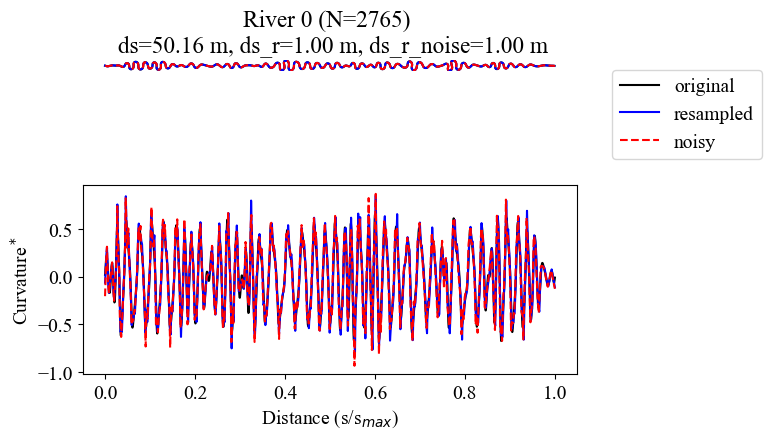

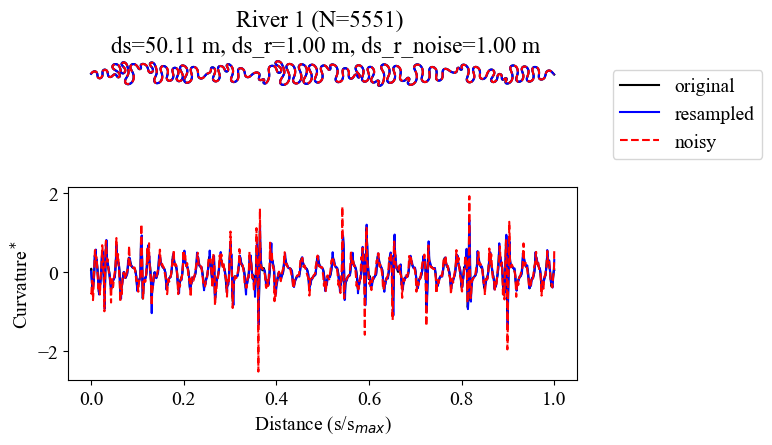

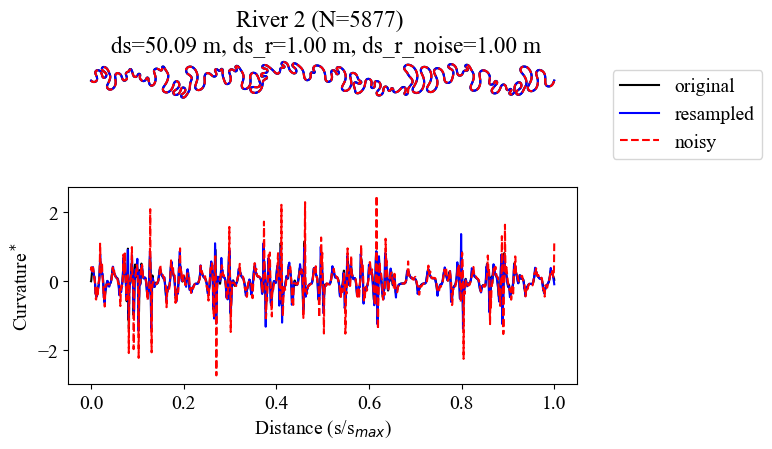

In [9]:
# Reset Figures
plt.close('all')
# Load river data
data = FM.load_data('synthetic_rivers/synthetic_rivers_w_noise.hdf5')
river_ids = list(data.keys())
# ------------------------------
# Arguments for the noise data
# ------------------------------
kwargs_resample = {
    '0':{'smooth': 1e2},
    '1':{'smooth': 1e2},
    '2':{'smooth': 1e2},
    '0_noise':{'smooth': 1e2},
    '1_noise':{'smooth': 1e3},
    '2_noise':{'smooth': 1e3},
    }

# ------------------------------
# Create Rivers class
# ------------------------------
rivers = RiverDatasets(logger=logger)
# ------------------------------
# Add Rives into class
# ------------------------------
i = 0
for river_id in river_ids:
    # ------------------------------
    # Add original river 
    # ------------------------------
    x_ch = data[river_id]['x']
    y_ch = data[river_id]['y']
    w_m = data[river_id]['w_m']
    rivers.add_river(river_id, x_ch, y_ch, w_m=w_m, resample_flag=True,
                     kwargs_resample=kwargs_resample[river_id],
                     scale_by_width=True)
    # Calculate curvature
    rivers[river_id].calculate_curvature()
    # ------------------------------
    # Add noisy river 
    # ------------------------------
    x_ch_noise = data[river_id]['x_noise']
    y_ch_noise = data[river_id]['y_noise']
    w_m = data[river_id]['w_m']
    rivers.add_river(
        f'{river_id}_noise', x_ch_noise, y_ch_noise, w_m=w_m,
        resample_flag=True,
        kwargs_resample=kwargs_resample[f'{river_id}_noise'],
        scale_by_width=True)
    # Calculate cuvature
    rivers[f'{river_id}_noise'].calculate_curvature()

for river_id in river_ids:
    # ------------------------------
    # Plot
    # ------------------------------
    x_ch = data[river_id]['x']
    y_ch = data[river_id]['y']
    c_ch = data[river_id]['c']
    s_ch = data[river_id]['s']
    ds_ch = data[river_id]['ds']
    x = rivers[river_id].x
    y = rivers[river_id].y
    c = rivers[river_id].c
    s = rivers[river_id].s
    ds = rivers[river_id].ds
    x_noise = rivers[f'{river_id}_noise'].x
    y_noise = rivers[f'{river_id}_noise'].y
    c_noise = rivers[f'{river_id}_noise'].c
    s_noise = rivers[f'{river_id}_noise'].s
    ds_noise = rivers[f'{river_id}_noise'].ds

    f, ax = plt.subplots(2, 1, figsize=(8, 5))
    # Plot river
    ax[0].plot(x_ch/w_m_gm, y_ch/w_m_gm, '-k', label='original')
    # ax[0].plot(x_ch, y_ch, '-k', label='original')
    ax[0].plot(x, y, '-b', label='resampled')
    ax[0].plot(x_noise, y_noise, '--r', label='noisy')
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title(
        f'River {river_id} (N={len(x_ch)}) \n ds={np.mean(ds_ch):.2f} m, '
        f'ds_r={ds:.2f} m, '
        f'ds_r_noise={ds_noise:.2f} m')
    # Remove axis lines
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Curvature
    # ax[1].plot(s_ch/np.max(s_ch), c_ch, '-k', label='original')
    ax[1].plot(s_ch/np.max(s_ch), c_ch*w_m_gm, '-k', label='original')
    ax[1].plot(s/np.max(s), c, '-b', label='resampled')
    ax[1].plot(s_noise/np.max(s_noise), c_noise, '--r', label='noisy')
    # if river_id == '0':
    # ax[1].set_ylim([-0.03, 0.03])
    # ax[1].set_ylim([-3, 3])
    ax[1].set_xlabel('Distance (s/s$_{max}$)')
    ax[1].set_ylabel(r'Curvature$^*$')
    plt.tight_layout()
    utl.cr_folder('synthetic_rivers/results/')
    plt.savefig(f'synthetic_rivers/results/river_{river_id}_curvature.png',
                dpi=300)
    plt.show()

# ------------------------------
# Save Rivers
# ------------------------------
# rivers.save_rivers(
#     f'synthetic_rivers/rivers_class/',
#     'river_network.hdf5', save_cwt_info=True)


 ### Multiscale Characterization

A multiscale characterization of meandering channels can be approached by taking a look at the wavelet signature in the curvature and the direction angle. The power in the spectrum shows the important wavelengths in the curvature signal that can be later used to determine the scale of the meanders. Few examples are shown below.



2024-05-02 16:13:34,024[INFO] info:  Scaling curvature by width


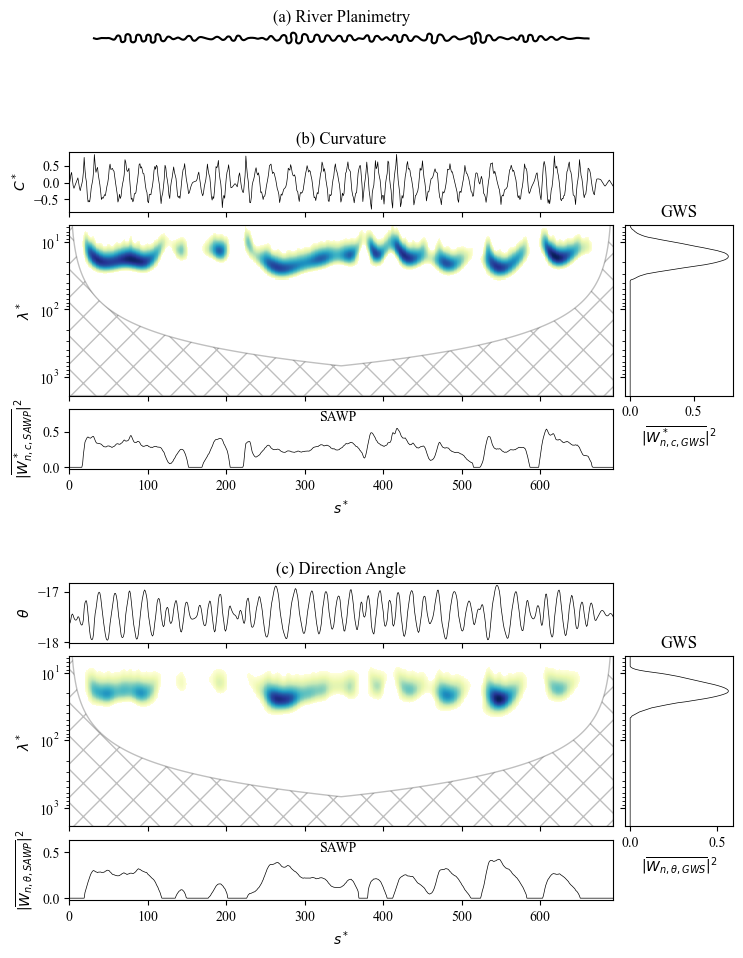

2024-05-02 16:13:35,303[INFO] info:  Scaling curvature by width


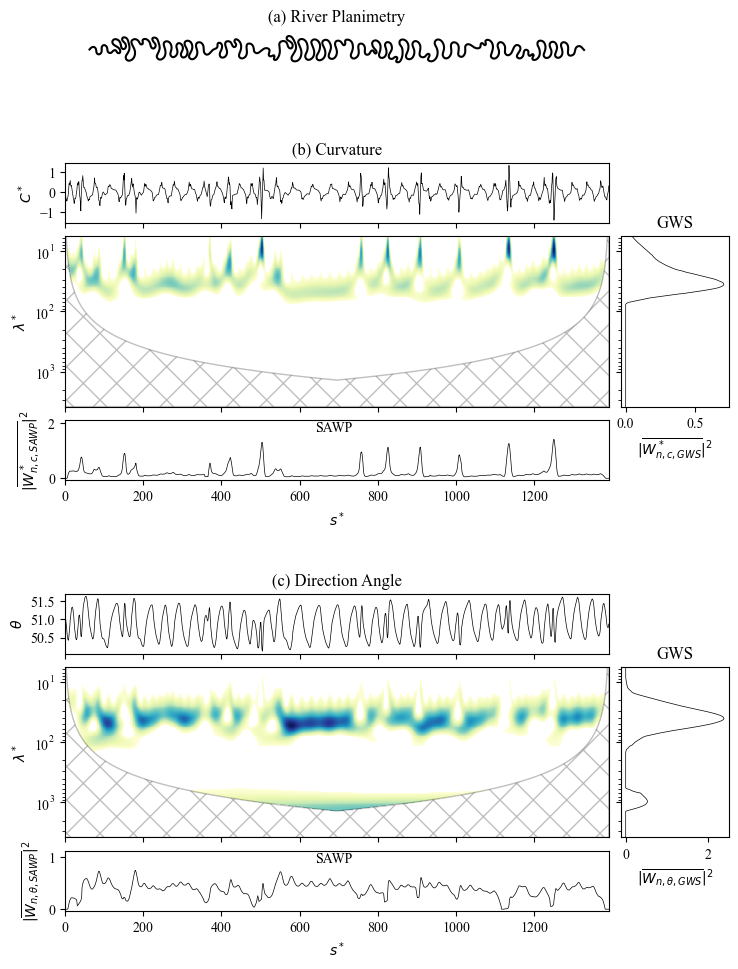

2024-05-02 16:13:36,707[INFO] info:  Scaling curvature by width


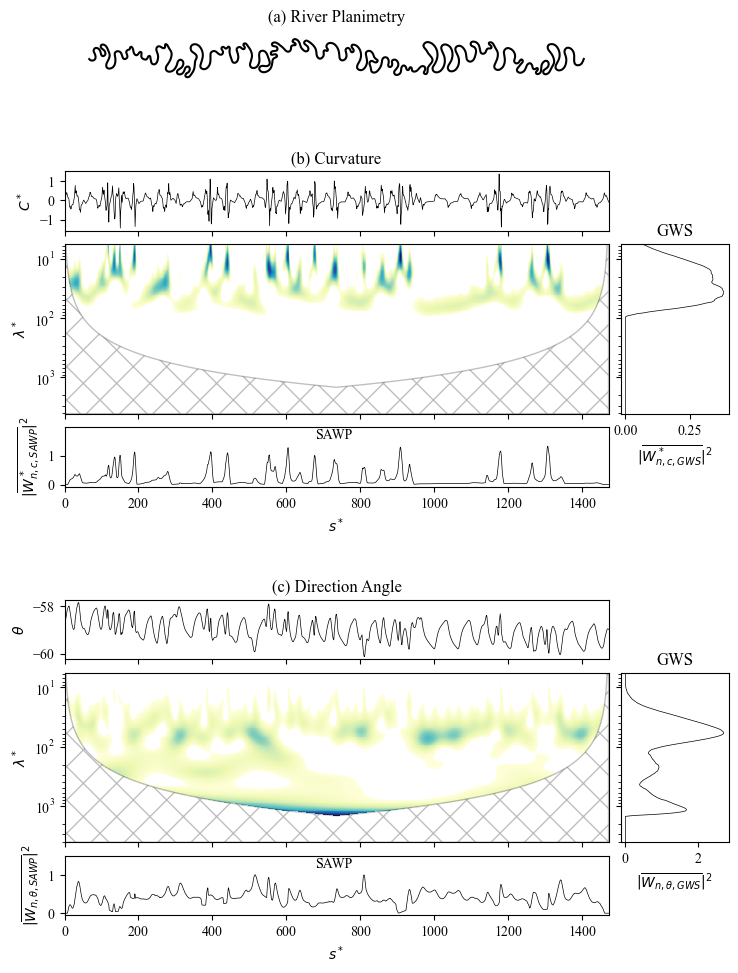

In [11]:
plt.close('all')
for river_id in river_ids:
    # Calculate curvature
    rivers[f'{river_id}'].calculate_curvature()
    # Calculate CWT
    rivers[f'{river_id}'].get_cwt_curvature(mother='MORLET')
    rivers[f'{river_id}'].get_cwt_angle(mother='MORLET')
    graphs.plot_river_spectrum_compiled(rivers[f'{river_id}'],
                                        only_significant=True)
    utl.cr_folder('synthetic_rivers/results/')
    if river_id == '2':
        utl.cr_folder('../manuscript_figures/')
        plt.savefig(f'../manuscript_figures/Figure_09_meanderpy_river_cwt.png',
                    dpi=500)
    elif river_id == '0':
        utl.cr_folder('../manuscript_figures/')
        plt.savefig(f'../manuscript_figures/Figure_S4_meanderpy_river_cwt.png',
                    dpi=500)
    else:
        utl.cr_folder('../manuscript_figures/')
        plt.savefig(f'../manuscript_figures/Figure_S5_meanderpy_river_cwt.png',
                    dpi=500)
    plt.show()


Additionally, we can compare the Global Wavelet Spectrum (GWS) and the Scale-Averaged Wavelet Power (SAWP) for the curvature and direction angle of the rivers we generated.

sigma 1.53: [16.53964345]
sigma 3.08: [35.45350185]
sigma 3.19: [19.66906167 21.08077833 35.45350185 39.33812333 42.16155665]
sigma 1.53: [18.35188345]
sigma 3.08: [ 40.72537926 954.0071237 ]
sigma 3.19: [  57.59438368  222.53003014 1174.52054064]


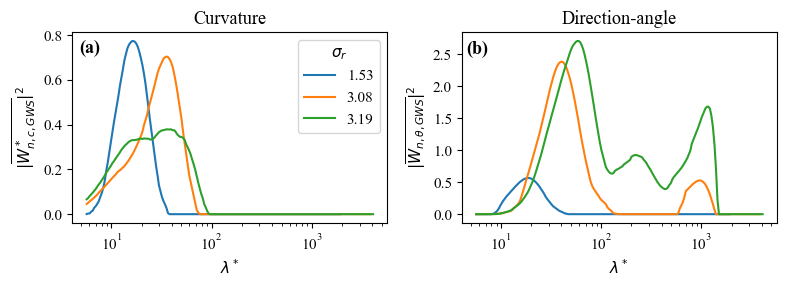

In [12]:
# --------------------
# Plot GWS information
# --------------------
fs = 11
mpl.rcParams['font.size'] = fs
plt.close('all')
# f, ax = plt.subplots(1, 2, figsize=(8, 5), sharex='col', sharey='row')
f, ax = plt.subplots(1, 2, figsize=(8, 3), sharex='col')
ax = ax.ravel()
i_dat = 0
ax[i_dat].set_title('Curvature')
for i in range(3):
    lambda_r = rivers[f'{i}'].s[-1]
    x = rivers[f'{i}'].x
    y = rivers[f'{i}'].y
    # Calculate distance between the first and last point of the river
    l_r = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
    sigma_r = lambda_r/l_r
    ax[i_dat].plot(rivers[f'{i}'].cwt_wavelength_c,
                   rivers[f'{i}'].cwt_gws_c_sig,
                   label=f'{sigma_r:.2f}')
    # Find peaks in gws
    gws = rivers[f'{i}'].cwt_gws_c_sig
    peaks, _ = find_peaks(gws, height=0)
    lambda_value = rivers[f'{i}'].cwt_wavelength_c[peaks]
    print(f'sigma {sigma_r:.2f}: {lambda_value}')
# ax[i_dat].set_xlabel(f'$\lambda$ (m)')
ax[i_dat].set_xlabel(r'$\lambda^*$')
# ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
ax[i_dat].set_ylabel(r"$|\overline{W^*_{n,c,GWS}}|^2$")
ax[i_dat].set_xscale('log')
ax[i_dat].legend(title='$\\sigma_r$')

i_dat = 1
ax[i_dat].set_title('Direction-angle')
for i in range(3):
    lambda_r = rivers[f'{i}'].s[-1]
    x = rivers[f'{i}'].x
    y = rivers[f'{i}'].y
    # Calculate distance between the first and last point of the river
    l_r = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
    sigma_r = lambda_r/l_r
    ax[i_dat].plot(rivers[f'{i}'].cwt_wavelength_angle,
             rivers[f'{i}'].cwt_gws_angle_sig,
             label='')
    # Find peaks in gws
    gws = rivers[f'{i}'].cwt_gws_angle_sig
    peaks, _ = find_peaks(gws, height=0)
    lambda_value = rivers[f'{i}'].cwt_wavelength_c[peaks]
    print(f'sigma {sigma_r:.2f}: {lambda_value}')
ax[i_dat].set_xlabel(r'$\lambda^*$')
ax[i_dat].set_ylabel(r"$|\overline{W_{n,\theta,GWS}}|^2$")
# ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
ax[i_dat].set_xscale('log')

# Literals
f.text(0.12, 0.80, '(a)', ha='center', fontsize=fs + 2, weight='bold')
f.text(0.605, 0.80, '(b)', ha='center', fontsize=fs + 2, weight='bold')


plt.tight_layout()
utl.cr_folder('../manuscript_figures/')
plt.savefig(f'../manuscript_figures/Figure_10_compare_GWS_meanderpy.png', dpi=500)
plt.show()


### Unsupservised Identification of Meanders

Now that we have a `RiverDatasets` class we can go ahead perform the automated extraction of meanders on the synthetic rivers.

#### Process to perform unsupervised Identification

The process to perform the automatic detection from a created rivers object involves the following steps:

1. **Calculate curvature**: Use the function `rivers[id_river].calculate_curvature()` to estimate the curvature of the river transect.

2. **Calculate Continous Wavelet Transform (CWT) of the curvature and extract tree**: Use the function `rivers[id_river].extract_cwt_tree()` to estimate the CWT of the curvature and extract the CWT tree where the important wavelengths are mapped throughout the network.

3. **Prune Peak Power**: Use the function `rivers[id_river].prune_tree_by_peak_power()` to prune the tree by the peak power of the CWT.

4. **Prune by sinuosity**: Use the function `rivers[id_river].prune_tree_by_sinuosity(1.01)` to prune the tree by the sinuosity of the river.

5. **Add meanders to database**: Use the function `rivers[id_river].add_meanders_from_tree_scales(bounds_array_str='extended')` to add the meanders to the database.

In [13]:
data_to_save = {}
# =================================
# Extract Meanders
# =================================
for river_id in river_ids:
    # =================================
    # Extract Meanders
    # =================================
    # --------------------
    # Calculate Curvature
    # --------------------
    rivers[f'{river_id}'].calculate_curvature()
    rivers[f'{river_id}_noise'].calculate_curvature()
    # --------------------
    # Calculate CWT
    # --------------------
    rivers[f'{river_id}'].extract_cwt_tree()
    rivers[f'{river_id}_noise'].extract_cwt_tree()
    # -----------------------------
    # Prune by peak power
    # -----------------------------
    rivers[f'{river_id}'].prune_tree_by_peak_power()
    rivers[f'{river_id}_noise'].prune_tree_by_peak_power()
    # -----------------------------
    # Prune by sinuosity
    # -----------------------------
    rivers[f'{river_id}'].prune_tree_by_sinuosity(1.01)
    rivers[f'{river_id}_noise'].prune_tree_by_sinuosity(1.01)
    # -----------------------------
    # Add meander to database
    # -----------------------------
    # rivers[f'{river_id}'].add_meanders_from_tree_scales(overwrite=True, clip='downstream')
    # rivers[f'{river_id}_noise'].add_meanders_from_tree_scales(overwrite=True, clip='downstream')
    rivers[f'{river_id}'].add_meanders_from_tree_scales(
        overwrite=True, clip='downstream', bounds_array_str='extended')
    rivers[f'{river_id}_noise'].add_meanders_from_tree_scales(
        overwrite=True, clip='downstream', bounds_array_str='extended')
    # ---------------------------
    # Calculate reach sinuosity
    # ---------------------------
    rivers[f'{river_id}'].calculate_reach_metrics()
    rivers[f'{river_id}_noise'].calculate_reach_metrics()


# ------------------------------
# Save Rivers
# ------------------------------
rivers.save_rivers(
    f'synthetic_rivers/rivers_class_cwt/',
    'river_network.hdf5', save_cwt_info=True)



2024-05-02 16:16:10,017[INFO] info:  Scaling curvature by width
2024-05-02 16:16:10,017[INFO] info:  Scaling curvature by width
2024-05-02 16:16:10,018[INFO] info:   Running CWT...


2024-05-02 16:16:10,029[INFO] info:   Getting the scale tree...
2024-05-02 16:16:10,212[INFO] info:   Finding peaks in CWT...
2024-05-02 16:16:10,228[INFO] info:   Detecting meanders...
2024-05-02 16:16:10,235[INFO] info:   Projecting tree in planimetry...
2024-05-02 16:16:10,300[WARNING] warning: Ending inflection point out of full meander bounds. Correcting to CWT bounds.
2024-05-02 16:16:10,304[WARNING] warning: Ending inflection point out of full meander bounds. Correcting to CWT bounds.
2024-05-02 16:16:10,314[WARNING] warning: Ending inflection point out of full meander bounds. Correcting to CWT bounds.
2024-05-02 16:16:10,315[WARNING] warning: Ending inflection point out of full meander bounds. Correcting to CWT bounds.
2024-05-02 16:16:10,316[WARNING] warning: Ending inflection point out of full meander bounds. Correcting to CWT bounds.
2024-05-02 16:16:10,325[INFO] info:   Running CWT...
2024-05-02 16:16:10,333[INFO] info:   Getting the scale tree...
2024-05-02 16:16:10,508[IN

#### Plot the Scale Space Tree

In the following code block we will plot an example of the space scale tree for one of the synthetic rivers. This plot is used in the manuscript as the example of the tree.

<>:72: SyntaxWarning: invalid escape sequence '\l'
<>:79: SyntaxWarning: invalid escape sequence '\l'
<>:72: SyntaxWarning: invalid escape sequence '\l'
<>:79: SyntaxWarning: invalid escape sequence '\l'
/var/folders/gd/tzwzt9s974lfs1vtwfplkmf80000gn/T/ipykernel_45807/2903558138.py:72: SyntaxWarning: invalid escape sequence '\l'
  ax[2].set_ylabel(f'$\lambda^*$')
/var/folders/gd/tzwzt9s974lfs1vtwfplkmf80000gn/T/ipykernel_45807/2903558138.py:79: SyntaxWarning: invalid escape sequence '\l'
  ax[3].set_ylabel(f'$\lambda^*$')


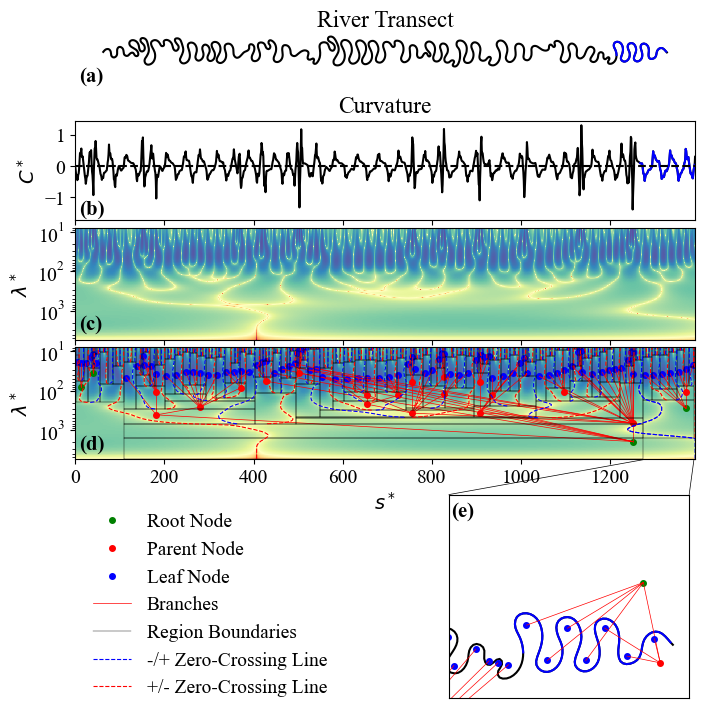

In [14]:
# ========================
# Plot Scale Space Tree
# ========================
# ------------------------
# Extract Information
# ------------------------
id_river = '1'
tree_id = 3
# id_river = '1'
# tree_id = 0
x = rivers[id_river].x
y = rivers[id_river].y
s = rivers[id_river].s
c = rivers[id_river].c
wavelength_c = rivers[id_river].cwt_wavelength_c
power_c = np.log2(rivers[id_river].cwt_power_c)
zc_lines = rivers[id_river].cwt_zc_lines
zc_sign = rivers[id_river].cwt_zc_sign
regions = rivers[id_river].cwt_regions
root_node = rivers[id_river].tree_scales[tree_id]
nodes = [root_node] + list(root_node.descendants)
# ------------------------
# Extract tree info
# ------------------------
idx_st = root_node.idx_leaf_start - 3
idx_end = root_node.idx_leaf_end
x_clip = x[idx_st:idx_end + 1]
y_clip = y[idx_st:idx_end + 1]
s_clip = s[idx_st:idx_end + 1]
c_clip = c[idx_st:idx_end + 1]
# wavelength_c_clip = wavelength_c[idx_st:idx_end + 1]
power_c_clip = power_c[:, idx_st:idx_end + 1]
# ------------------------
# Plot Tree
# ------------------------
fs = 14
mpl.rcParams['font.size'] = fs
mpl.rcParams['font.family'] = 'Times New Roman'
kwargs = {'linewidth': 0.5, 'markersize': 4}
plt.close('all')

f, ax = plt.subplots(5, 1, figsize=(8, 8))
# Plot River Planimetry
ax[0].plot(x, y, '-k')
ax[0].plot(x_clip, y_clip, '-b')
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f'River Transect')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

# Plot curvature
ax[1].plot(s, c, '-k')
ax[1].plot(s_clip, c_clip, '-b')
ax[1].axhline(0, color='k', linestyle='--')
ax[1].set_ylabel(f'$C^*$')
ax[1].set_title(f'Curvature')
ax[1].set_xlim([s[0], s[-1]])
ax[1].set_xticklabels([])
ax[1].set_ylim(bottom=np.min(c) - 0.35)

# plot cwt
ax[2].pcolormesh(s, wavelength_c, power_c, cmap='Spectral')
ax[2].set_yscale('log')
ax[2].set_ylim([wavelength_c[-1], wavelength_c[0]])
ax[2].set_xlim(s[0], s[-1])
ax[2].set_xticklabels([])
# ax[2].set_xlim(s_clip[0], s_clip[-1])
ax[2].set_ylabel(f'$\lambda^*$')

ax[3].pcolormesh(s, wavelength_c, power_c, cmap='Spectral')
ax[3].set_yscale('log')
ax[3].set_ylim([wavelength_c[-1], wavelength_c[0]])
ax[3].set_xlim(s[0], s[-1])
# ax[2].set_xlim(s_clip[0], s_clip[-1])
ax[3].set_ylabel(f'$\lambda^*$')
ax[3].set_xlabel(f'$s^*$')

# Re-plot River Planimetry
ax[4].plot(x, y, '-k')
ax[4].plot(x_clip, y_clip, '-b')
ax[4].set_aspect('equal', adjustable='box')
ax[4].set_xticks([])
ax[4].set_yticks([])
# Include complete river
ax[4].set_xlim([x_clip[0] - 20, x_clip[-1] + 5] )
ax[4].set_ylim([y_clip.min() - 7, y_clip.max() + 32] )

# Plot tree nodes
flags = [True, True, True, True, True, True]
tree_ids = list(rivers[id_river].tree_scales.trees)
for tree_id in tree_ids:
    root_node = rivers[id_river].tree_scales[tree_id]
    nodes = [root_node] + list(root_node.descendants)
    for node in nodes:

        if node.is_leaf and not node.is_meander:
            continue
        if node.is_meander == 1:
            if flags[0]:
                ax[3].plot(node.s_c, node.wavelength_c, 'ob', label='Leaf Node', **kwargs)
                flags[0] = False
            else:
                ax[3].plot(node.s_c, node.wavelength_c, 'ob', **kwargs)
            ax[4].plot(node.x_c, node.y_c, 'ob', **kwargs)
        elif node.root_node == 1:
            if flags[1]:
                ax[3].plot(node.s_c, node.wavelength_c, 'og', label='Root Node', **kwargs)
                flags[1] = False
            else:
                ax[3].plot(node.s_c, node.wavelength_c, 'og', **kwargs)
            ax[4].plot(node.x_c, node.y_c, 'og', **kwargs)
        else:
            if flags[2]:
                ax[3].plot(node.s_c, node.wavelength_c, 'or', label='Parent Node', **kwargs)
                flags[2] = False
            else:
                ax[3].plot(node.s_c, node.wavelength_c, 'or', **kwargs)
            ax[4].plot(node.x_c, node.y_c, 'or', **kwargs)
        if node.parent is not None:
            if flags[3] and flags[0] == False and flags[1] == False and flags[2] == False:
                ax[3].plot(
                    [node.s_c, node.parent.s_c],
                    [node.wavelength_c, node.parent.wavelength_c],
                    color='r', label='Branches', **kwargs)
                flags[3] = False
            else:
                ax[3].plot(
                    [node.s_c, node.parent.s_c],
                    [node.wavelength_c, node.parent.wavelength_c],
                    color='r', **kwargs)
            ax[4].plot(
                [node.x_c, node.parent.x_c],
                [node.y_c, node.parent.y_c],
                color='r', **kwargs)

# Plot regions
regions_2 = copy.deepcopy(regions)
regions_2[:, 0] = wavelength_c[regions_2[:, 0].astype(int)]
regions_2[:, 1] = wavelength_c[regions_2[:, 1].astype(int)]
regions_2[:, 2] = s[regions_2[:, 2].astype(int)]
regions_2[:, 3] = s[regions_2[:, 3].astype(int)]
columns_1 = np.array([2, 2, 3, 3, 2])
columns_2 = np.array([0, 1, 1, 0, 0])
ax[3].plot(regions_2[1, columns_1].T, regions_2[1, columns_2].T, 'k', lw=0.3,
           label='Region Boundaries')
ax[3].plot(regions_2[2:, columns_1].T, regions_2[2:, columns_2].T, 'k', lw=0.3)
# Plot zc_lines
for czc, z_c in enumerate(zc_lines):
    if isinstance(z_c, int):
        continue
    if zc_sign[czc] == 1:
        if flags[4]:
            ax[3].plot(
                s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--r',
                label='+/- Zero-Crossing Line',
                lw=0.8)
            flags[4] = False
        else:
            ax[3].plot(s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--r', lw=0.8)
    else:
        if flags[5]:
            ax[3].plot(
                s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--b',
                label='-/+ Zero-Crossing Line',
                lw=0.8)
            flags[5] = False
        else:
            ax[3].plot(s[z_c[:, 1]], wavelength_c[z_c[:, 0]], '--b', lw=0.8)

plt.subplots_adjust(bottom=0.18, top=0.9)
# Move things around
box = ax[2].get_position()
ax[2].set_position([box.x0, box.y0, box.width, box.height + 0.015])
box = ax[3].get_position()
ax[3].set_position([box.x0, box.y0, box.width, box.height + 0.015])
box = ax[4].get_position()
ax[4].set_position([
    box.x0 + 0.13, box.y0 - 0.15, box.width + 0.2, box.height + 0.13])

box = ax[4].get_position()
x_box = [box.x0, box.x0 + 0.245]
y_box = [box.y0 + box.height, box.y0 + box.height + 0.044]
plt.plot(x_box, y_box, '-k', lw=0.5, transform=f.transFigure, clip_on=False)
x_box = [box.x0 + box.width, box.x0 + box.width + 0.006]
y_box = [box.y0 + box.height, box.y0 + box.height + 0.044]
plt.plot(x_box, y_box, '-k', lw=0.5, transform=f.transFigure, clip_on=False)

# Include legend in 3
ax[3].legend(bbox_to_anchor=(0, -2.3), loc='lower left', frameon=False)

# Text
f.text(0.13, 0.8, f'(a)', fontsize=15, fontweight='bold')
f.text(0.13, 0.634, f'(b)', fontsize=15, fontweight='bold')
f.text(0.13, 0.49, f'(c)', fontsize=15, fontweight='bold')
f.text(0.13, 0.34, f'(d)', fontsize=15, fontweight='bold')
f.text(0.595, 0.257, f'(e)', fontsize=15, fontweight='bold')
# Finish plot
# ax[2].legend()
# plt.tight_layout()
utl.cr_folder('../manuscript_figures/')
plt.savefig('../manuscript_figures/Figure_03_Automated_Process.png', dpi=500,
            bbox_inches='tight')
plt.show()

### Plot scale space tree

The following code block plots the scale space tree of one of river networks for analysis.

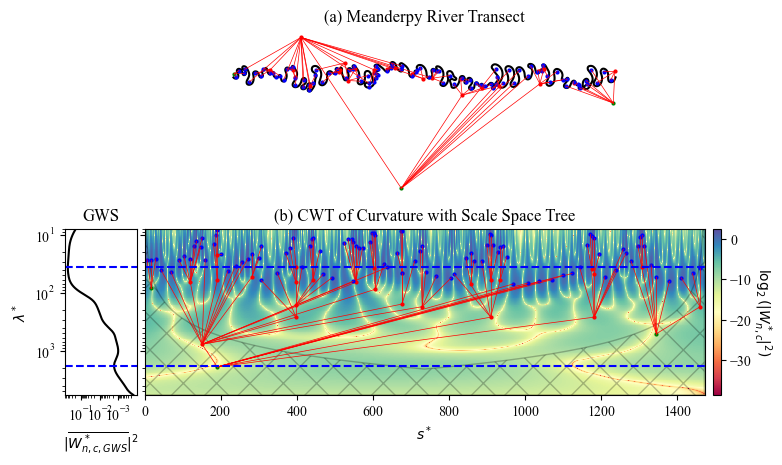

In [17]:
id_river = '2'
fs = 10
mpl.rcParams['font.size'] = fs
rivers[id_river].plot_tree_nodes(markersize=2, linewidth=0.5, title='Meanderpy River Transect')
utl.cr_folder('../manuscript_figures/')
plt.savefig(f'../manuscript_figures/Figure_11_river_meanderpy.png', dpi=300)

We can also use this information to explore the metrics of the meanders, as shown below.

In [20]:
meander_database = rivers[id_river].database
print(meander_database.shape)
# print(meander_database['sigma_hm'].describe())
meander_database[['R_hm', 'sigma_hm', 'sigma_fm', 'a_hm', 'FF']].describe()

(83, 60)


,R_hm,sigma_hm,sigma_fm,a_hm,FF
count,83.000000,83.000000,83.000000,83.000000,83.000000
mean,2.530248,2.140429,2.693513,-0.295949,1.558478
std,1.345896,0.686343,1.375405,0.362384,0.954893
min,0.960353,1.016033,1.060052,-1.000000,1.000000
25%,1.366705,1.683048,1.672438,-0.516401,1.000000
50%,2.101136,2.174913,2.454993,-0.397725,1.187203
75%,3.459353,2.568537,3.213335,-0.075504,1.684302
max,5.979616,4.887375,7.894925,0.712945,5.945880


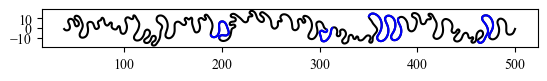

In [21]:
max_ff = meander_database['FF'].max()
subset_max_ff = meander_database[meander_database['FF'] >= 2.5]
x_max_ff = subset_max_ff['x'].values
y_max_ff = subset_max_ff['y'].values

plt.close('all')
plt.figure()
plt.plot(rivers[id_river].x, rivers[id_river].y, '-k')
iter = 0
for i in range(len(x_max_ff)):
    if iter == 0:
        # plt.plot(x_max_ff[i], y_max_ff[i], '-r')
        iter = 1
    else:
        plt.plot(x_max_ff[i], y_max_ff[i], '-b')
        iter = 0
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The meanders highlighted in the plot are the ones with a Funneling Factor (FF) larger or equal to 2.5.

## References

Howard, A. D., & Knutson, T. R. (1984). Sufficient conditions for river meandering: A simulation approach. Water Resources Research, 20(11), 1659–1667. https://doi.org/10.1029/WR020i011p01659

Sylvester, Z. (2023, September 14). zsylvester/meanderpy. Python. Retrieved from https://github.com/zsylvester/meanderpy (Original work published November 21, 2018)
